# MLP using Automatic Differentiation

***
**Name**: Payoj Jain
***

## Goal

The goal of this assignment is to build 1 layer MLP network using the framework that you built in **Assignment 3**.

In [1]:
from tensor import Tensor
import numpy as np
from sklearn.datasets import make_classification

### 1. Implementing the model

In [2]:
class MLP(object):
    def __init__(self, n_in, n_hid, n_out):
        """
        Initialize Layers (hidden and output) of the network.
        Note: Tensors are used here instead of ndarrays, operations
        on tensors such as dot, add, subtract, pow will allow us
        to keep track of the computational graph, thereby making
        gradient computation easier using a simple call to the 
        loss (MSE in this case).
        
        params:
        n_in (int): Number of input neurons.
        n_hid (int): Number of neurons in hidden layer.
        n_out (int): Number of neurons in output layer. 
        """

        self.l1 = Tensor(np.random.randn(n_in, n_hid))
        self.l2 = Tensor(np.random.randn(n_hid, n_out))

    def forward(self, X):
        """
        Implement the forward pass.

        params:
        X (NxM Tensor):
            M dimensional input to be feed forward to the network.

        returns:

        y_hat (1xN Tensor): activations of the output layer.
        """
        # TO-DO
        # Obtain final layer activations using tensors.
        # Unlike Assignment 3, you do not need to hold intermediate
        # values here as the AD architecture will build the computational
        # graph you.
#         raise NotImplementedError()

        z1 = X.dot(self.l1)
        g1 = z1.relu()
        z2 = g1.dot(self.l2)
        g2 = z2.relu()
        
        return g2
    
    def update(self, step_size):
        """
        Implement the update rule for network weights and biases.

        return:

        none.
        """
        # TO-DO
#         raise NotImplementedError()
        self.l1.value -=  step_size*self.l1.grad
        self.l2.value -=  step_size*self.l2.grad
        
    def zero_grad(self):
        """
        Resets gradients for each layer defined in
        the constructor.
        """
        # TO-DO
        self.l1.zero_grad()
        self.l2.zero_grad()
#         raise NotImplementedError()

### 2. Train the model 

In [3]:
def train(model, X, y, epochs, lr, batch_size):
    """
    Implement the train loop.
    Make sure gradients are reset after each call to forward.
    
    params:
    model (MLP): 1-hidden-layer MLP model to be trained.
    X (Nx5 ndarray): Training inputs.
    y (Nx1 ndarray): Groundtruth labels.
    epochs (int): number of epochs for training
    lr (float32): Learning-rate/Step-size for gradient descent. 
    
    returns:
    Implementation choice.
    """
    # TO-DO
    # For each mini batch, do the following:
    # 1. Obtain predictions using forward().
    # 2. Compute MSE loss.
    # 3. Accumulate layer gradients using the backward call
    #    on loss.
    # 4. update() layer weights using gradient descent.
    #   NOTE: you do not need to maintain computational
    #
#     raise NotImplementedError()
    from sklearn.utils import shuffle
    mean_squared_error = []

    for epoch in range(epochs):
        X, y = shuffle(X, y)        
        epoch_error = 0

        for batch in range(0,X.shape[0],batch_size):
            
            X_train = Tensor(X[batch:batch+batch_size])
            y_train = Tensor(y[batch:batch+batch_size])
            
            y_hat = model.forward(X_train)
            
            model.zero_grad()
            
            mse = (y_train - y_hat).pow(2).mean()
            mse.backward()
            
            model.update(lr)
            
            epoch_error += mse.value
            
        mean_error = epoch_error/(X.shape[0]/batch_size)
        mean_squared_error.append(mean_error)
    return mean_squared_error

### 3. Experiment
***

**Part 3.A**  

Create a model with $I = 5$ inputs, $H = 100$ and $O = 1$ output neuron. Train the model for 100 epochs using the dataset below. Plot the MSE loss for each epoch. You do not need to threshold/binarize the outputs.

In [12]:
# Do-not modify this.
# Load dataset.
X, y = np.load("data/X.npy"), np.load("data/y.npy")

In [13]:
# Part 3.A
mlp = MLP(5,100,1)
error = train(mlp,X,y,100,0.000005,10)

In [14]:
from matplotlib import pyplot as plt

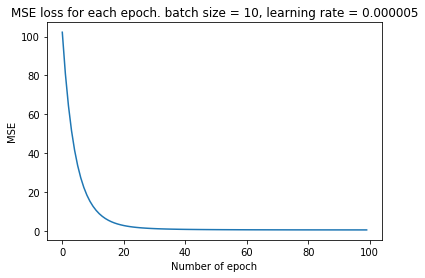

In [15]:
plt.plot([i for i in range(len(error))],error)
plt.title('MSE loss for each epoch. batch size = 10, learning rate = 0.000005')
plt.xlabel('Number of epoch')
plt.ylabel('MSE')

**Part 3.B**

Modify the `train()` to `train_decay()` such that learning rate decays after a condition has been met. For example: 
1. If running loss stays with a limit for 'e' number of epochs.
2. Or a constant weight decay after 'e' number of epochs.

Plot MSE loss for **3.A and 3.B** on the same graph.

> __Note__: I have chosen to change the learning rate when the change in loss is less than 10% for continuous 5 epochs. 

In [8]:
def train_decay(model, X, y, epochs, lr, decay, batch_size):
    
    mean_squared_errors = []
    old_error = 0
    epoch_count = 0 
    for epoch in range(epochs):
        
        from sklearn.utils import shuffle
        epoch_error = 0
        X, y = shuffle(X, y)

        for batch in range(0,X.shape[0],batch_size):
            
            X_train = Tensor(X[batch:batch+batch_size])
            y_train = Tensor(y[batch:batch+batch_size])
            
            y_hat = model.forward(X_train)
            
            model.zero_grad()
            
            mse = (y_train - y_hat).pow(2).mean()
            mse.backward()
            
            model.update(lr)
            
            epoch_error += mse.value
            
        mean_error = epoch_error/(X.shape[0]/batch_size)
        mean_squared_errors.append(mean_error)
        
        # Change the lr if change in error is within 10% for 5 continuous epochs
        
        if epoch > 1 and (0.9 * old_error < mean_error < 1.1 *old_error):
            epoch_count += 1
            if epoch_count == 5:
                lr /= decay
                epoch_count = 0
        old_error = mean_error
    return mean_squared_errors

> __Note__: I have deep copied the weights from the first network to the network __with decay learning rate__. To compare the behavior of learning rate the initial conditions of the networks have to be the same. 

In [28]:
import copy
mlp = MLP(5,100,1)
l1 = copy.deepcopy(mlp.l1.value)
l2 = copy.deepcopy(mlp.l2.value)
mlp_decay = MLP(5,100,1)
mlp_decay.l1 = Tensor(l1)
mlp_decay.l2 = Tensor(l2)

In [29]:
lr_error = train_decay(mlp,X,y,100,0.00001,1,10)
decay_error = train_decay(mlp_decay,X,y,100,0.00001,1.5,10)

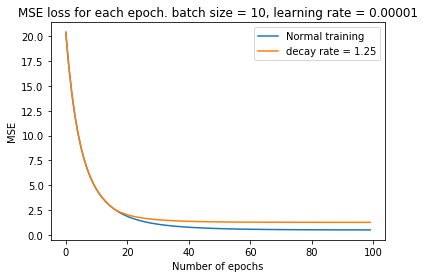

In [30]:
plt.plot([i for i in range(len(lr_error))],lr_error, label='Normal training')
plt.plot([i for i in range(len(decay_error))],decay_error, label='decay rate = 1.25')
plt.title('MSE loss for each epoch. batch size = 10, learning rate = 0.00001')
plt.xlabel('Number of epochs')
plt.ylabel('MSE')
plt.legend()